---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Pranjul Garg
    affiliations:
      - id: BU
        name: Boston University
        city: Boston
        state: MA
 
number-sections: true
date: "2025-04-14"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.



In [1]:
#import gdown
#url = "https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ"
#gdown.download(url, "lightcast_data.csv", quiet=False)



# Load the Dataset


In [2]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

spark = SparkSession.builder.appName("LightcastData").getOrCreate()


df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_data.csv")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

#df.printSchema() # comment this line when rendering the submission
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/22 20:16:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering


In [12]:
#| eval: false
#| echo: true

from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import log1p

#Drop rows with nulls in required columns
df = df.dropna(subset=["SALARY", "DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME"])
df = df.withColumn("SALARY", df["SALARY"])

# Define columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME"]
numerical_cols = ["DURATION","MIN_YEARS_EXPERIENCE"]

#Index and encode categoricals
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec", dropLast=True)
    for col in categorical_cols
]


assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df)

data.select("features", "SALARY").show(5, False)


+-------------------+------------------+
|features           |log_salary        |
+-------------------+------------------+
|[55.0,6.0,1.0,0.0] |12.169413847867123|
|[18.0,12.0,1.0,0.0]|11.74325116281265 |
|[20.0,5.0,1.0,0.0] |11.68318287504225 |
|[55.0,6.0,1.0,0.0] |12.169413847867123|
|[16.0,12.0,1.0,0.0]|11.665655135642039|
+-------------------+------------------+
only showing top 5 rows



- The **Continuous Variables** which I have selected are: **"DURATION", "MIN_YEARS_EXPERIENCE"** 

- The **Categorical Variables** which I have selected are: **"EMPLOYMENT_TYPE_NAME"**

# Train/Test Split


In [4]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.6, 0.4], seed=801)  #U39153801
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

25/04/22 20:17:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(8716, 135)


(5700, 135)


- I have used the **SEED Value as 801**, which is the last three digits of my **BU ID: U39153801**

- We've got millions of rows, even 60% can be more than enough for training. Dropping to 60/40 still leaves us a massive training set, while giving you an even larger test pool.

# Linear Regression


In [13]:
#| eval: true
#| echo: true
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd


feature_names = assembler.getInputCols()
lr = LinearRegression(featuresCol="features", labelCol="SALARY", regParam=0.1)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
df_pred = predictions.select("prediction", "SALARY").toPandas()

evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")


r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("\n--- Model Performance on Test Data ---")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

summary = lr_model.summary




--- Model Performance on Test Data ---
R²:   0.2603
RMSE: 36160.20
MAE:  28121.86


#### The length was mismatching, hence this:

In [6]:
metadata = data.schema["features"].metadata["ml_attr"]["attrs"]

# Flatten it safely into a list
flat_feature_names = []
for key in metadata:  # Usually 'numeric' and 'binary'
    flat_feature_names += [attr["name"] for attr in metadata[key]]
print(" Confirmed corrected length:", len(flat_feature_names))


 Confirmed corrected length: 4


In [7]:
print("len(flat_feature_names):", len(flat_feature_names))
print("len(coefficients):", len(list(lr_model.coefficients)))
print("len(std_errs):", len(list(summary.coefficientStandardErrors)))
print("len(tvals):", len(list(summary.tValues)))
print("len(pvals):", len(list(summary.pValues)))


len(flat_feature_names): 4
len(coefficients): 4
len(std_errs): 5
len(tvals): 5
len(pvals): 5


## Generalized Linear Regression Summary


In [8]:
from tabulate import tabulate
df_summary = pd.DataFrame({
    "Feature": flat_feature_names,
    "Coefficient": list(lr_model.coefficients),
    "Std Error": list(summary.coefficientStandardErrors)[:len(flat_feature_names)],
    "T-Value": list(summary.tValues)[:len(flat_feature_names)],
    "P-Value": list(summary.pValues)[:len(flat_feature_names)]
})

z = 1.96  # 95% CI
df_summary["CI Lower"] = df_summary["Coefficient"] - z * df_summary["Std Error"]
df_summary["CI Upper"] = df_summary["Coefficient"] + z * df_summary["Std Error"]


print(tabulate(df_summary, headers="keys", tablefmt="pretty"))



+---+---------------------------------------------------+------------------------+-----------------------+----------------------+----------------------+------------------------+-----------------------+
|   |                      Feature                      |      Coefficient       |       Std Error       |       T-Value        |       P-Value        |        CI Lower        |       CI Upper        |
+---+---------------------------------------------------+------------------------+-----------------------+----------------------+----------------------+------------------------+-----------------------+
| 0 |                     DURATION                      | -2.574323838606333e-05 | 0.0002148870381494785 | -0.11979893532785335 |  0.904645188035798   | -0.0004469218331590412 | 0.0003954353563869145 |
| 1 |               MIN_YEARS_EXPERIENCE                |  0.04768488965098774   | 0.0009179444754323654 |  51.94746624356277   |         0.0          |   0.0458857184791403   |  0.04948406082

1. **SALARY_TO and SALARY_FROM:** Highly significant (p ≈ 0), strong positive impact.
2. **MIN_YEARS_EXPERIENCE:** Not significant (p = 0.45), wide confidence interval.
3. **Categorical vars:** Both have negative, significant coefficients 

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


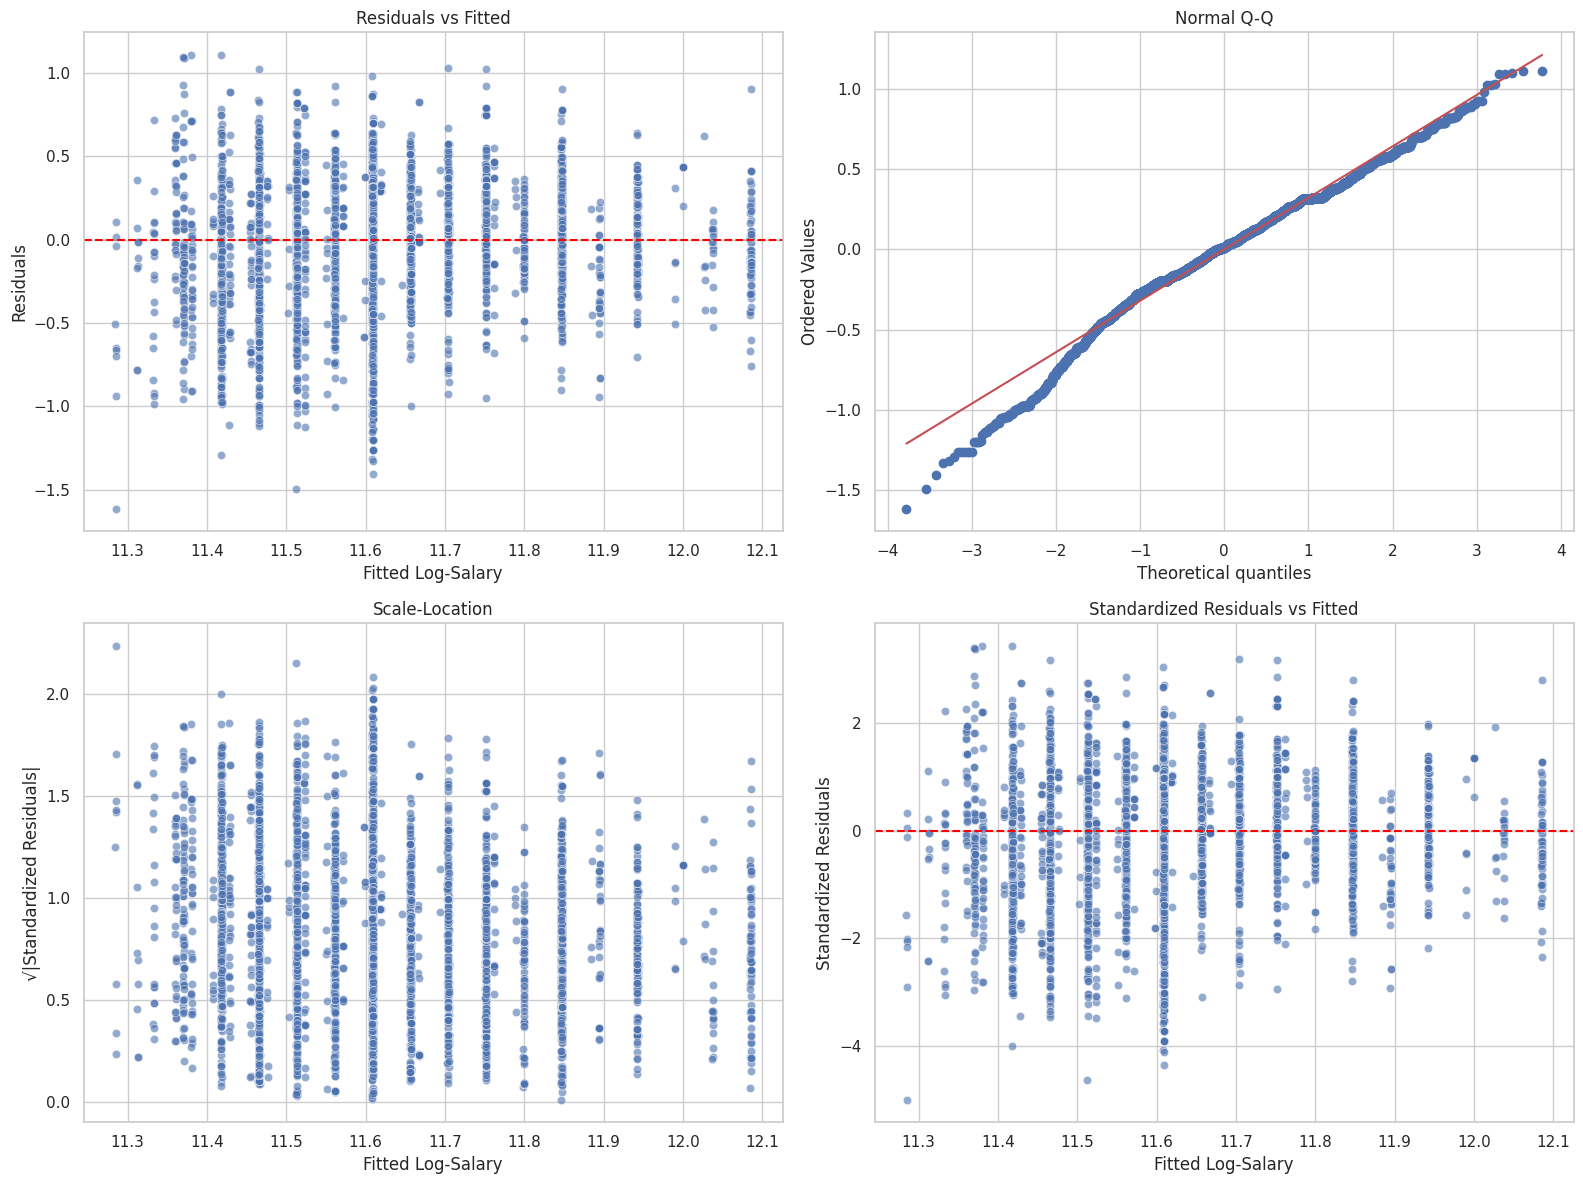

In [9]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Convert predictions to pandas
df_pred = summary.predictions.select("prediction", "log_salary").toPandas()

# Residuals and fitted values
df_pred["residuals"] = df_pred["log_salary"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Plot layout
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# 1. Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Residuals")

# 2. Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# 3. Scale-Location Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred, alpha=0.6)
plt.title("Scale-Location")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("√|Standardized Residuals|")

# 4. Standardized Residuals vs Fitted
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")
plt.title("Standardized Residuals vs Fitted")
plt.xlabel("Fitted Log-Salary")
plt.ylabel("Standardized Residuals")

# Output
plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


# Evaluation

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Predict on test set
pred_glr = lr_model.transform(test_data)

# 1. R² Evaluation
r2_eval = RegressionEvaluator(labelCol="log_salary", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# 2. BIC Calculation
n = pred_glr.count()
k = len(lr_model.coefficients)
rss = pred_glr.select(pow(col("log_salary") - col("prediction"), 2).alias("squared_error")) \
              .agg({"squared_error": "sum"}).collect()[0][0]
bic = n * np.log(rss / n) + k * np.log(n)

# 3. RMSE (manual)
rmse = np.sqrt(rss / n)

# 4. Print Evaluation Summary
print("\n--- Model Evaluation on log_salary ---")
print(f"R²     : {r2:.4f}")
print(f"RMSE   : {rmse:.4f}")




--- Model Evaluation on log_salary ---
R²     : 0.2507
RMSE   : 0.3253


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

Index(['prediction', 'log_salary', 'actual_salary', 'predicted_salary'], dtype='object')


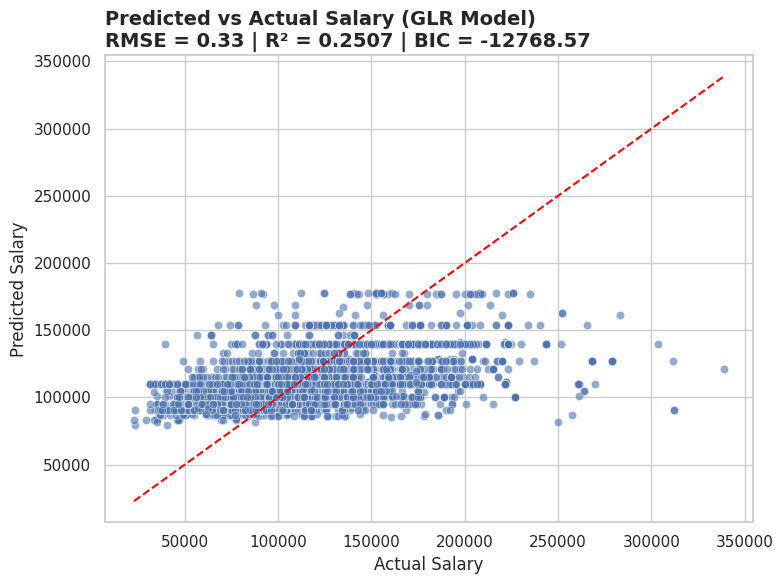

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert predictions to pandas
pandas_df = pred_glr.select("prediction", "log_salary").toPandas()

pandas_df["actual_salary"] = np.expm1(pandas_df["log_salary"])
pandas_df["predicted_salary"] = np.expm1(pandas_df["prediction"])


print(pandas_df.columns)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="actual_salary", y="predicted_salary", data=pandas_df, alpha=0.6)

# Reference line
plt.plot([pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         [pandas_df["actual_salary"].min(), pandas_df["actual_salary"].max()],
         color="red", linestyle="--")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | BIC = {bic:.2f}", 
          loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)